In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse
%matplotlib inline  

# Download the 10x Dataset `1k Brain Cells from an E18 Mouse (v2 chemistry)`

10x datasets are available at
https://support.10xgenomics.com/single-cell-gene-expression/datasets

The page for the `1k Brain Cells from an E18 Mouse (v2 chemistry)` dataset is
https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/neuron_1k_v2

But the FASTQ files (7.4GB) can be downloaded with `wget` directly (without giving them email info) from http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v2/neuron_1k_v2_fastqs.tar

In the cell below we check if the dataset file `neuron_1k_v2_fastqs.tar` already exists. If not we download the dataset to the same directory as this notebook


In [2]:
#Check if the file was downloaded already before doing wget:
if not (os.path.isfile('./neuron_1k_v2_fastqs.tar')): 
    # the `!` means we're running a command line statement (rather than python)  
    !wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v2/neuron_1k_v2_fastqs.tar
else: print('Dataset already downloaded!')


--2018-12-03 16:58:37--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v2/neuron_1k_v2_fastqs.tar
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.35.99.80, 13.35.99.77, 13.35.99.113, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.35.99.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7971788800 (7.4G) [application/x-tar]
Saving to: ‘neuron_1k_v2_fastqs.tar’

100%[====================================>] 7,971,788,800 29.1MB/s   in 3m 28s 

2018-12-03 17:02:11 (36.5 MB/s) - ‘neuron_1k_v2_fastqs.tar’ saved [7971788800/7971788800]



Because this dataset was run on two lanes, we need to uncompress the FASTQ files and concatenate them before using kallisto bus. If we had a single file kallisto could take gz files as is.

In [3]:
# now we untar the fastq files on neuron_1k_v2_fastqs folder
!tar -xvf ./neuron_1k_v2_fastqs.tar

neuron_1k_v2_fastqs/
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_I1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R2_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_I1_001.fastq.gz
neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R2_001.fastq.gz


# Buiding the kallisto index

First make sure that kallisto is installed and the version is greater than 0.45

If it's not installed, see instructions at https://pachterlab.github.io/kallisto/download

In [4]:
!kallisto version 

kallisto, version 0.45.0


First we build the kallisto index for the dataset. 
The index is built from the published reference transcriptome for each organism.
Building the index takes a few minutes and needs to be done only once for each organism.

### Download reference transcriptome from ensembl
In order to do that we first download the mouse transcriptome from ensembl, you can see the reference genomes they have at https://uswest.ensembl.org/info/data/ftp/index.html

In [5]:
#Check if the file was downloaded already before doing wget:
if not (os.path.isfile('Mus_musculus.GRCm38.cdna.all.fa.gz')): 
    # the `!` means we're running a command line statement (rather than python)  
    !wget ftp://ftp.ensembl.org/pub/release-94/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz
else: print('Mouse transcriptome already downloaded!')


--2018-12-03 17:02:29--  ftp://ftp.ensembl.org/pub/release-94/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz
           => ‘Mus_musculus.GRCm38.cdna.all.fa.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.8
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.8|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-94/fasta/mus_musculus/cdna ... done.
==> SIZE Mus_musculus.GRCm38.cdna.all.fa.gz ... 50809568
==> PASV ... done.    ==> RETR Mus_musculus.GRCm38.cdna.all.fa.gz ... done.
Length: 50809568 (48M) (unauthoritative)

100%[======================================>] 50,809,568  3.25MB/s   in 16s    

2018-12-03 17:02:52 (3.03 MB/s) - ‘Mus_musculus.GRCm38.cdna.all.fa.gz’ saved [50809568]



In [6]:
### Now we can build the index
if not (os.path.isfile('mouse_transcripts.idx')): 
    !kallisto index -i mouse_transcripts.idx Mus_musculus.GRCm38.cdna.all.fa.gz
else: print ('Mouse transcript index already exist!')


[build] loading fasta file Mus_musculus.GRCm38.cdna.all.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 600 target sequences
[build] warning: replaced 3 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 711215 contigs and contains 98989067 k-mers 



# Preparing transcript_to_gene.tsv file process the single cell data with kallisto bus

Depending on which transcriptome you used, you will need to create a file translating transcripts to genes. This notebook assumes the file is in `transcript_to_gene.tsv`, for ensembl transcriptomes these can be generated using biomart.

The general format of `transcript_to_gene.tsv` is

```
ENST00000632684.1	ENSG00000282431.1
ENST00000434970.2	ENSG00000237235.2
ENST00000448914.1	ENSG00000228985.1
ENST00000415118.1	ENSG00000223997.1
ENST00000631435.1	ENSG00000282253.1
...
```

To create the `transcript_to_gene.tsv` we fetch and parse the mouse GTF file from ensembl.

The reference GTF files are available at https://uswest.ensembl.org/info/data/ftp/index.html

The mouse ones which we use are at ftp://ftp.ensembl.org/pub/release-94/gtf/mus_musculus

In [7]:
#Check if the file was downloaded already before doing wget:
if not (os.path.isfile('Mus_musculus.GRCm38.94.gtf.gz') or os.path.isfile('Mus_musculus.GRCm38.94.gtf')): 
    # the `!` means we're running a command line statement (rather than python)  
    !wget ftp://ftp.ensembl.org/pub/release-94/gtf/mus_musculus/Mus_musculus.GRCm38.94.gtf.gz
else: print('Mouse transcriptome already downloaded!')


--2018-12-03 17:06:41--  ftp://ftp.ensembl.org/pub/release-94/gtf/mus_musculus/Mus_musculus.GRCm38.94.gtf.gz
           => ‘Mus_musculus.GRCm38.94.gtf.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.8
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.8|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-94/gtf/mus_musculus ... done.
==> SIZE Mus_musculus.GRCm38.94.gtf.gz ... 29397390
==> PASV ... done.    ==> RETR Mus_musculus.GRCm38.94.gtf.gz ... done.
Length: 29397390 (28M) (unauthoritative)

100%[======================================>] 29,397,390  3.00MB/s   in 9.3s   

2018-12-03 17:06:57 (3.01 MB/s) - ‘Mus_musculus.GRCm38.94.gtf.gz’ saved [29397390]



In [8]:
# Unzip the file
!gunzip ./Mus_musculus.GRCm38.94.gtf.gz

## Create transcript_to_gene.tsv

Now we can use the cells below to parse the GTF file and keep only the transcript mapping as a tsv file in the format below.
```
ENST00000632684.1	ENSG00000282431.1
ENST00000434970.2	ENSG00000237235.2
ENST00000448914.1	ENSG00000228985.1
```

In [9]:
def create_transcript_list(input, use_name = False, use_version = True):
    r = {}
    for line in input:
        if len(line) == 0 or line[0] == '#':
            continue
        l = line.strip().split('\t')
        if l[2] == 'transcript':
            info = l[8]
            d = {}
            for x in info.split('; '):
                x = x.strip()
                p = x.find(' ')
                if p == -1:
                    continue
                k = x[:p]
                p = x.find('"',p)
                p2 = x.find('"',p+1)
                v = x[p+1:p2]
                d[k] = v


            if 'transcript_id' not in d or 'gene_id' not in d:
                continue

            tid = d['transcript_id']
            gid = d['gene_id']
            if use_version:
                if 'transcript_version' not in d or 'gene_version' not in d:
                    continue

                tid += '.' + d['transcript_version']
                gid += '.' + d['gene_version']
            gname = None
            if use_name:
                if 'gene_name' not in d:
                    continue
                gname = d['gene_name']

            if tid in r:
                continue

            r[tid] = (gid, gname)
    return r



def print_output(output, r, use_name = True):
    for tid in r:
        if use_name:
            output.write("%s\t%s\t%s\n"%(tid, r[tid][0], r[tid][1]))
        else:
            output.write("%s\t%s\n"%(tid, r[tid][0]))

In [10]:
with open('./Mus_musculus.GRCm38.94.gtf') as file:
    r = create_transcript_list(file, use_name = False, use_version = True)
with open('transcript_to_gene.tsv', "w+") as output:
    print_output(output, r, use_name = False)
print('Created transcript_to_gene.tsv file')

Created transcript_to_gene.tsv file


# Run kallisto bus
kallisto bus supports several single cell sequencing technologies, as you can see below. We'll be using 10xv2            

In [11]:
!kallisto bus --list

List of supported single cell technologies

short name       description
----------       -----------
10Xv1            10X chemistry version 1
10Xv2            10X chemistry verison 2
DropSeq          DropSeq
inDrop           inDrop
CELSeq           CEL-Seq
CELSeq2          CEL-Seq version 2
SCRBSeq          SCRB-Seq



In [12]:
!kallisto bus -i mouse_transcripts.idx  -o out_1k_mouse_brain_v2 -x 10xv2 -t 4 \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R1_001.fastq.gz \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R2_001.fastq.gz \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R1_001.fastq.gz \
./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R2_001.fastq.gz


[index] k-mer length: 31
[index] number of targets: 115,270
[index] number of k-mers: 98,989,067
[index] number of equivalence classes: 419,171
[quant] will process sample 1: ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R1_001.fastq.gz
                               ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L001_R2_001.fastq.gz
[quant] will process sample 2: ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R1_001.fastq.gz
                               ./neuron_1k_v2_fastqs/neuron_1k_v2_S1_L002_R2_001.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 104,846,299 reads, 73,297,108 reads pseudoaligned


### The `matrix.ec` file

The `matrix.ec` is generated by kallisto and connects the equivalence class ids to sets of transcripts. The format looks like
~~~
0	0
1	1
2	2
3	3
4	4
...

884398	26558,53383,53384,69915,69931,85319,109252,125730
884399	7750,35941,114698,119265
884400	9585,70083,92571,138545,138546
884401	90512,90513,134202,159456
~~~

In [13]:
#load transcript to gene file
tr2g = {}
trlist = []
with open('./transcript_to_gene.tsv') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('./out_1k_mouse_brain_v2/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

### Processing the BUS file

For these notebooks we will work with the text file that `BUStools` produces, rather than the raw `BUS` file. 
To install `BUStools` see https://github.com/BUStools/bustools

We discard any barcodes that don't have more 10 UMIs 

To produce the text file, starting with the `output.bus` file produced by kallisto, we first sort it on bustools:
```
bustools sort -o output.sorted output.bus
```
Then we convert it to txt:
```
bustools text -o output.sorted.txt output.sorted
```



In [14]:
#sort bus file
!bustools sort -o ./out_1k_mouse_brain_v2/output.sorted ./out_1k_mouse_brain_v2/output.bus

Read in 73297108 number of busrecords
All sorted


In [15]:
# convert the sorted busfile to txt
!bustools text -o ./out_1k_mouse_brain_v2/output.sorted.txt ./out_1k_mouse_brain_v2/output.sorted

Read in 21115457 number of busrecords


# Plot the bus file results

In [16]:
import csv
from collections import defaultdict

# precompute because this is constant per ec
ec2g = {ec:frozenset(tr2g[trlist[t]] for t in ecs[ec]) for ec in ecs}

# first pass: collect gene sets
bcu_gs = dict()

with open('./out_1k_mouse_brain_v2/output.sorted.txt') as f:
    rdr = csv.reader(f, delimiter='\t')
    for bar,umi,ec,_ in rdr:
        gs = ec2g[int(ec)]

        if (bar,umi) in bcu_gs:
            bcu_gs[bar,umi].intersection_update(gs)
        else:
            bcu_gs[bar,umi] = set(gs)

# second pass: compute gene counts
cell_gene = defaultdict(lambda: defaultdict(float))

for (bar,umi),gs in bcu_gs.items():
    for g in gs:
        cell_gene[bar][g] += 1.0 / len(gs)

# finally: filter out barcodes below threshold
cell_gene = {bar:cell_gene[bar] for bar in cell_gene
              if sum(cell_gene[bar].values()) >= 10.0}

In [17]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s
    

### Download the 10x whitelist

In [18]:
!wget https://github.com/10XGenomics/supernova/blob/master/tenkit/lib/python/tenkit/barcodes/737K-august-2016.txt

--2018-12-03 17:13:32--  https://github.com/10XGenomics/supernova/blob/master/tenkit/lib/python/tenkit/barcodes/737K-august-2016.txt
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘737K-august-2016.txt’

    [ <=>                                   ] 56,530      --.-K/s   in 0.06s   

2018-12-03 17:13:37 (993 KB/s) - ‘737K-august-2016.txt’ saved [56530]



In [19]:
whitelist = set(x.strip() for x in open('737K-august-2016.txt'))

### Plot counts

1291


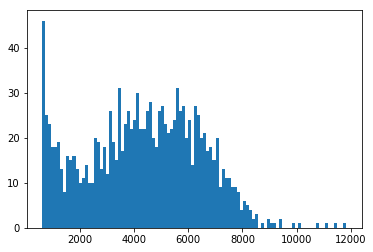

In [20]:
bcv = [x for b,x in barcode_hist.items() if x > 600 and x < 12000]
_ = plt.hist(bcv,bins=100)
print(len(bcv))